In [ ]:
!pip install gym[all]
!pip install gym[accept-rom-license]
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import traceback

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

from collections import deque
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the Replay Buffer Class

In [ ]:

# create replay buffer of tuples of (state, next_state, action, reward, done)
# Initially keep storing the samples in the Buffers, then start sampling from it for getting IID Samples
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        
        self.max_size = max_size # Max size of Replay Buffer
        self.storage = []
        self.pointer = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.pointer)] = data
            self.pointer = (self.pointer + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        uniform_samples = np.random.randint(0, len(self.storage), size=batch_size) # pi
        x, y, u, r, d = [], [], [], [], []

        for i in uniform_samples : 
            X, Y, U, R, D = self.storage[i] # Using Optimal Control terminology--> 
            u.append(np.array(U, copy=False))# Control Uk ( the optimal control term for Action )
            r.append(np.array(R, copy=False)) # reward 
            d.append(np.array(D, copy=False)) # Buffer size of Replay Buffer
            x.append(np.array(X, copy=False)) # Xk - current state
            y.append(np.array(Y, copy=False))
            

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

# Environment Wrappers Copied from Open AI Baseline BELOW

# ** ** *** ** ** *** *** *** ** *** *** *** *** ** ** ** *** *** *** *** *** *** *** *** ** *** *** ** ** ***

In [ ]:
# from: https://github.com/openai/baselines/baselines/common/atari_wrappers.py
# from: https://github.com/Officium/RL-Experiments/blob/master/src/common/wrappers.py 

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [ ]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few
            # frames so it's important to keep lives > 0, so that we only reset
            # once the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        shape = (2, ) + env.observation_space.shape
        self._obs_buffer = np.zeros(shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = info = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [ ]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    @staticmethod
    def reward(reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        shape = (1 if self.grayscale else 3, self.height, self.width)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=np.uint8
        )

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        size = (self.width, self.height)
        frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame.transpose((2, 0, 1))

In [ ]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also `LazyFrames`
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        shape = (shp[0] * k, ) + shp[1:]
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=env.observation_space.dtype
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return np.asarray(self._get_ob())

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return np.asarray(self._get_ob()), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


In [ ]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are
        only stored once. It exists purely to optimize memory usage which can be
        huge for DQN's 1M frames replay buffers.
        This object should only be converted to numpy array before being passed
        to the model. You'd not believe how complex the previous solution was.
        """
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-3)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

In [ ]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0
    
    
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env, width=84, height=84)
    env = MaxAndSkipEnv(env, skip=4)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

# ** ** *** ** ** *** *** *** ** *** *** *** *** ** ** ** *** *** *** *** *** *** *** *** ** *** *** ** ** ***

# Wrapper Env code ends here. NOTE - The ABOVE Wrapper code is from OpenAI baseline 

# Q1.a Loading the Pong Environment & Printing the details of Next State & rewards by interacting with the Environment

In [ ]:
#create Pong env and test it a bit
#env = gym.make('PongNoFrameskip-v4') #
env = gym.make("Pong-v0")#gym.make("ALE/Pong-v5") #gym.make("Pong-v0")#('PongNoFrameskip-v4')
print('Action Space-->',env.action_space)
print('Observation Space-->',env.observation_space)
print('reward range-->',env.reward_range)
print('Meta data --> ',env.metadata)
print('Specifications -->',env.spec)
env.reset()
all_rewards =[]
#for i in range(3000):
timestamp =0
sample_count = 250
while True :
    timestamp += 1
    env.render(mode = 'rgb_array')
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    if sample_count >0:
      print(' reward is {}'.format(reward ))
      all_rewards.append(reward)
      sample_count -= 1

    if done:
        print('Episode finished after {} timesteps with reward {}'.format(timestamp, reward))
        
        env.reset()
        break
print('max reward is --> {} and min reward --> {}'.format(max(all_rewards), min(all_rewards)))
env.close()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.


Action Space--> Discrete(6)
Observation Space--> Box(0, 255, (210, 160, 3), uint8)
reward range--> (-inf, inf)
Meta data -->  {'render_modes': ['human', 'rgb_array']}
Specifications --> EnvSpec(id='Pong-v0', entry_point='gym.envs.atari:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=10000, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={'game': 'pong', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': (2, 5)}, namespace=None, name='Pong', version=0)
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward is 0.0
 reward i

# Deep Q Network - Here a CNN

In [ ]:
# create Deep Q Network Class by inheriting from torch.nn.Module
            
class DeepQNet(nn.Module):
    def __init__(self, action_space_size, hidden_size):
        # defining the convolution & dense layers
        super(DeepQNet, self).__init__()
        self.convolution_layer_1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.convolution_layer_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.convolution_layer_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense_layer = nn.Linear(7 * 7 * 64, hidden_size)
        self.out_layer = nn.Linear(hidden_size, action_space_size)

    def forward(self, x):
        x = x / 255. # image data is stored as ints in 0 to 255 range. Divide to scale to 0 to 1 range
        x = F.relu(self.convolution_layer_1(x))
        x = F.relu(self.convolution_layer_2(x))
        x = F.relu(self.convolution_layer_3(x))
        x = F.relu(self.dense_layer(x.view(x.size(0), -1)))
        return self.out_layer(x)

# DQN Agent Classn- methods for training & epsilon greedy action selection

In [ ]:
class DQNAgent():
    def __init__(self, action_space_size, hidden_size, learning_rate ):
        self.action_space_size = action_space_size
        self.target_net = DeepQNet(action_space_size, hidden_size).to(device)# moving the model to GPU memory
        self.train_net = DeepQNet(action_space_size, hidden_size).to(device)
        
        self.target_net.load_state_dict(self.train_net.state_dict()) # copying train net parameters to target net
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)

        
    def select_action(self, states, epsilon):
        # applying Epsilon-Greedy method for selecting the Next Action
        if np.random.rand() <= epsilon :
            action = env.action_space.sample() # with Epsilon probability, choose actions randomly
        else:
            # GREEDY action is the LARGEST Q value from the train network based on the input. with Probability (1-Epsilon) we do Greedy Action selection
            with torch.no_grad():
                input_state = torch.FloatTensor(np.array(states)).unsqueeze(0).to(device)
                action = self.train_net(input_state).max(1)[1]#.view(1, 1)#.detach().cpu().numpy()[0]
                action = int(action)
        return action

    
    def train(self, replay_buffer, batch_size, discount_factor):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, action, reward, done = replay_buffer.sample(batch_size)
        # convert these batches of Samples into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(action).to(device)
        reward_batch = torch.FloatTensor(reward).to(device)
        done_batch = torch.FloatTensor(1. - done).to(device)

        # get train net Q values
        train_q = self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Q values
        with torch.no_grad():
            target_net_q = reward_batch + done_batch * discount_factor * \
                     torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)
            
        # get loss between train q values and target q values
            # DQN implementations typically use MSE loss or Huber loss (smooth_l1_loss is similar to Huber)
        #loss_fn = nn.MSELoss()
        #loss = loss_fn(train_q, target_net_q) 
        loss = F.smooth_l1_loss(train_q, target_net_q)
        
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.train_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()   
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network "update_every" iterations, SET in the Next HYPERPARAMETER cell
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            #print("Updating target network parameters")
            self.target_net.load_state_dict(self.train_net.state_dict())    

# SET Hyperparameters + Create Deep Q Net

In [ ]:
# Initialize env and set up hyperparameters
env = gym.make("Pong-v0") #env = gym.make('PongNoFrameskip-v4')

# wrap env
env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)
action_space_size = env.action_space.n

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
timesteps = 2000000 # run env for this many time steps--- We are supposed to run a 2 or 2.5 million minimum
#timesteps =  20000 # run env for this many time steps--- We are supposed to run a 2 or 2.5 million minimum
hidden_size = 512   # side of hidden layer of FFNN that connects CNN to outputs

discount_factor = 0.99 # discount future states by
learning_rate = 0.0001 # learning rate of optimizer
batch_size = 32    # size of batch trained on
start_training_after = 10001 # start training NN after this many timesteps

epsilon_start = 1.0 # epsilon greedy start value
epsilon_min = 0.01  # epsilon greedy end value
epsilon_decay_steps = timesteps * .15 # decay epsilon over this many timesteps
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

update_target_every = 1000 # update target network every this steps

# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

# create DQN Agent
dqn_agent = DQNAgent(action_space_size, hidden_size, learning_rate)

# Colab Mount & PATH creation & Checkpoint Save & Retrieval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os.path
from os import path
RL_A4_path = '/content/drive/MyDrive/Colab_Notebooks_IITH/RL_A4'
if path.exists(RL_A4_path) == False:
  os.makedirs(RL_A4_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import sys 

def save_checkpoint(epochs, train_net, target_net, optimizer, reward=0, latest_episode =0,  stats_every=10):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving checkpoint...")
    torch.save({
                'epoch': epochs,
                'train_net_state_dict': train_net.state_dict(),
                'target_net_state_dict': train_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, os.path.join(RL_A4_path, 'DQN_Pong.pth'))
    with open(os.path.join(RL_A4_path, str(stats_every)+"episode_mean_reward.txt"),"a") as myfile: # a- Append mode
              myfile.write(str(latest_episode)+'_'+str(epochs)+'_'+str(reward)+'\n')
    

def load_checkpoint(RL_A4_path , train_net,target_net , optimizer):
    checkpoint = torch.load(os.path.join(RL_A4_path, 'DQN_Pong.pth'))
    train_net.load_state_dict(checkpoint['train_net_state_dict'])
    target_net.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return train_net,target_net, optimizer, checkpoint['epoch']

def load_Reward_Seq(checkpoint_fpath):
  my_file = open(os.path.join(RL_A4_path, str(stats_every)+"episode_mean_reward.txt"), "r")
  data = my_file.read()
  my_file.close()
  #data_into_list = data.split("\n")[:-1]
  #data_into_list = list(map(int, data_into_list))
  data_into_list = data.split("\n")
  episode_num = [int(x.split('_')[0]) for x in data_into_list if '_' in x  ]
  epochs = [int(x.split('_')[1])  for x in data_into_list if '_' in x  ]
  mean_reward = [float(x.split('_')[2])  for x in data_into_list if '_' in x  ]
  return episode_num, epochs, mean_reward

# Training Parameters Initializations

In [ ]:
stats_rewards_list = [] # store traininig statistics for plotting in this
stats_every = 10 # print the traininig statistics every this many episodes

epsilon = epsilon_start
state = env.reset()
load_from_checkpoint = 1

total_reward = 0
episode = 1
episode_length = 0
stats_loss = 0.

# Training Starts Next

In [ ]:


if load_from_checkpoint ==1 :
  try :
    dqn_agent.train_net,dqn_agent.target_net, dqn_agent.optimizer, epochs  = load_checkpoint(RL_A4_path, 
                                                                                             dqn_agent.train_net,
                                                                                             dqn_agent.target_net , 
                                                                                             dqn_agent.optimizer)
    episodes,_,_= load_Reward_Seq(RL_A4_path)
    episode = episodes[-1]
    #(checkpoint_fpath , train_net,target_net , optimizer)
    print('Restarted training from Checkpoint. Previous checkpoint --> {} epochs. Episode--> {}'.format(epochs, episode))
    episode+= 1
  except Exception as e: 
    epochs = 0 
    print(e)
    

for ts in range(epochs, timesteps+epochs):
    #env.render()
    # select an action from the agent's policy
    action = dqn_agent.select_action(state, epsilon)
    # decay epsilon
    epsilon -= epsilon_step
    if epsilon < epsilon_min:
        epsilon = epsilon_min
            
    # enter action into the env
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    episode_length += 1
    
    # add experience to replay buffer
    replay_buffer.add((state, next_state, action, reward, float(done)))
    
    if ts > start_training_after:
        # train the agent
        stats_loss += dqn_agent.train(replay_buffer, batch_size, discount_factor)
        # update the target network every (if conditions are met in update_target_network)
        dqn_agent.update_target_network(ts, update_target_every)
    
    if done:
        state = env.reset()
        stats_rewards_list.append((episode, total_reward, episode_length))
        episode += 1
        total_reward = 0
        episode_length = 0

        if ts > start_training_after and episode % stats_every == 0:
            n_episode_mean_reward =  np.mean(stats_rewards_list[-stats_every:],axis=0)[1]
            #save_checkpoint(epochs, train_net, target_net, optimizer, reward=0, latest_episode =0,  stats_every=10)
            save_checkpoint(ts, dqn_agent.train_net,dqn_agent.target_net,  dqn_agent.optimizer, n_episode_mean_reward, episode, stats_every)
            print('Episode: {};'.format(episode),' Timestep: {};'.format(ts),stats_every,
                '-Episode Mean reward: {:.1f};'.format(n_episode_mean_reward ),
                'Episode length: {:.1f};'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                'Epsilon: {:.2f};'.format(epsilon), 'Loss: {:.4f}'.format(stats_loss))
            stats_loss = 0.
        
        # stopping condition for training if agent reaches the amount of reward
        if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 19:
            print("Stopping at episode {} with average rewards of {} in last {} episodes".
                format(episode, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
            break  
    else:
        state = next_state

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab_Notebooks_IITH/RL_A4/DQN_Pong.pth'
Saving checkpoint...
Episode: 40;  Timestep: 11383; 10 -Episode Mean reward: -20.8; Episode length: 298.2; Epsilon: 0.96; Loss: 47.5351
Saving checkpoint...
Episode: 50;  Timestep: 14440; 10 -Episode Mean reward: -20.3; Episode length: 305.7; Epsilon: 0.95; Loss: 63.7018
Saving checkpoint...
Episode: 60;  Timestep: 17497; 10 -Episode Mean reward: -20.3; Episode length: 305.7; Epsilon: 0.94; Loss: 49.4591
Saving checkpoint...
Episode: 70;  Timestep: 20356; 10 -Episode Mean reward: -20.6; Episode length: 285.9; Epsilon: 0.93; Loss: 43.5817
Saving checkpoint...
Episode: 80;  Timestep: 23389; 10 -Episode Mean reward: -20.5; Episode length: 303.3; Epsilon: 0.92; Loss: 42.4383
Saving checkpoint...
Episode: 90;  Timestep: 26526; 10 -Episode Mean reward: -20.1; Episode length: 313.7; Epsilon: 0.91; Loss: 37.0632
Saving checkpoint...
Episode: 100;  Timestep: 29572; 10 -Episode Mean reward: -20.

# PLOTTING Mean n-Episode Reward vs timestep (or Episodes)

In [ ]:
episode_num, epochs, mean_reward = load_Reward_Seq(RL_A4_path)

Text(0, 0.5, 'Episode Reward')

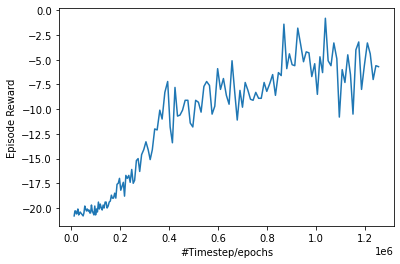

In [ ]:
#for episodes, reward in zip(episode_num, mean_reward):
# plot rewards
plt.plot(epochs, mean_reward)
plt.xlabel('#Timestep/epochs')
plt.ylabel('Episode Reward')

max episode no. is 1570 ; max epoch/timestep is 1255366


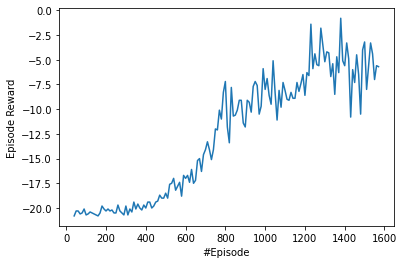

In [ ]:

plt.plot(episode_num, mean_reward)
plt.xlabel('#Episode')
plt.ylabel('Episode Reward')
print('max episode no. is {} ; max epoch/timestep is {}'.format(episode_num[-1],epochs[-1] ))